In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [14]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# we want to work on Numpy arrays and not pandas dataframes 
data = np.array(data)
m, n = data.shape # get rows and columns
np.random.shuffle(data)
# Taking 1000 examples for validation | Using the rest for training | Separating features (X) from labels (Y)
# set aside certain data for cross validation to check parameter values 
data_dev = data[0:1000].T
# Y_dev gets the first row (now a column after transpose) - these are your labels/targets
Y_dev = data_dev[0] 
# X_dev gets all other rows - these are your features
X_dev = data_dev[1:n]
# Normalizes the feature values by dividing by 255 (pixel values range from 0-255)
X_dev = X_dev/255. 

# rest is training data 
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train/255.
_, m_train = X_train.shape


In [16]:
Y_train

array([5, 6, 8, ..., 7, 8, 3])

In [17]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
X_train[:, 0].shape

(784,)

Our NN will have a simple two-layer architecture. Input layer  𝑎[0]
  will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer  𝑎[1]
  will have 10 units with ReLU activation, and finally our output layer  𝑎[2]
  will have 10 units corresponding to the ten digit classes with softmax activation.

In [19]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2 

def ReLU_deriv(Z):
    return Z > 0 

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [20]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print('iteration: ', i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [21]:
W1, b1, W2, b2, = gradient_descent(X_train, Y_train, 0.10, 500)

iteration:  0
[3 3 6 ... 3 8 3] [5 6 8 ... 7 8 3]
0.10619512195121951
iteration:  10
[8 1 6 ... 9 6 3] [5 6 8 ... 7 8 3]
0.15285365853658536
iteration:  20
[8 1 6 ... 4 8 3] [5 6 8 ... 7 8 3]
0.18853658536585366
iteration:  30
[8 1 6 ... 4 8 3] [5 6 8 ... 7 8 3]
0.21141463414634146
iteration:  40
[8 6 9 ... 4 8 3] [5 6 8 ... 7 8 3]
0.2434390243902439
iteration:  50
[8 9 9 ... 4 8 3] [5 6 8 ... 7 8 3]
0.27787804878048783
iteration:  60
[7 9 9 ... 4 8 3] [5 6 8 ... 7 8 3]
0.3079512195121951
iteration:  70
[8 9 9 ... 4 8 3] [5 6 8 ... 7 8 3]
0.34146341463414637
iteration:  80
[8 9 8 ... 4 8 3] [5 6 8 ... 7 8 3]
0.3814390243902439
iteration:  90
[8 9 8 ... 4 8 3] [5 6 8 ... 7 8 3]
0.4220731707317073
iteration:  100
[8 8 8 ... 4 8 3] [5 6 8 ... 7 8 3]
0.46407317073170734
iteration:  110
[5 6 8 ... 4 8 3] [5 6 8 ... 7 8 3]
0.5121219512195122
iteration:  120
[5 6 8 ... 4 8 3] [5 6 8 ... 7 8 3]
0.5600487804878049
iteration:  130
[5 6 8 ... 4 8 3] [5 6 8 ... 7 8 3]
0.6001219512195122
iteration:

# 85% accuracy on training set

In [22]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation = 'nearest')
    plt.show()

Prediction:  [5]
Label:  5


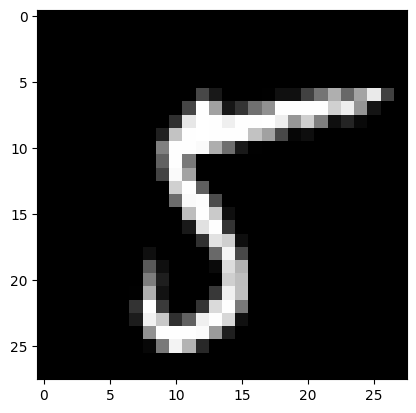

Prediction:  [3]
Label:  5


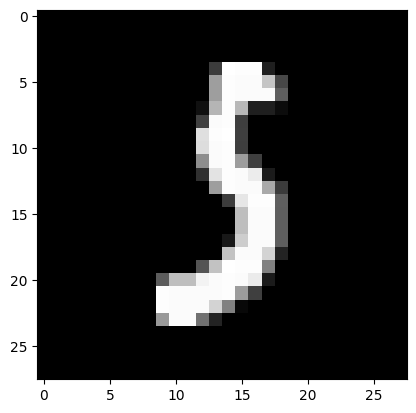

Prediction:  [7]
Label:  7


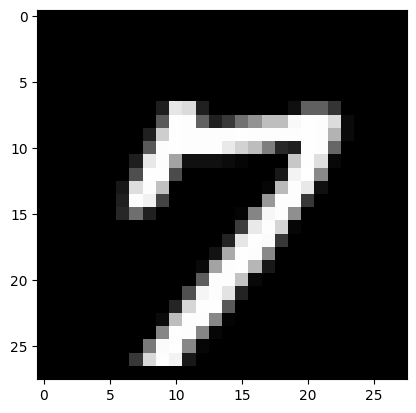

Prediction:  [1]
Label:  1


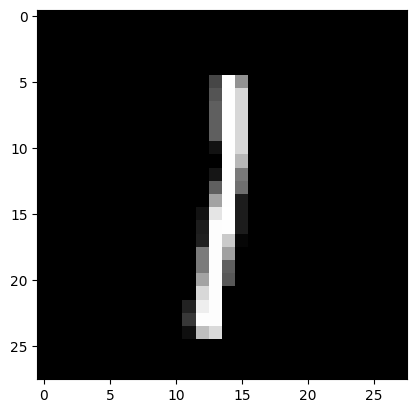

In [23]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(10, W1, b1, W2, b2)
test_prediction(110, W1, b1, W2, b2)
test_prediction(120, W1, b1, W2, b2)

In [24]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[6 7 6 9 3 1 5 8 1 1 5 1 9 9 8 0 8 0 2 0 1 3 9 3 6 5 4 5 5 3 8 8 9 0 4 4 3
 6 0 9 6 2 9 2 8 4 6 7 7 7 0 8 7 5 6 0 3 1 7 5 3 3 1 1 4 5 5 9 5 1 6 3 6 5
 8 7 9 9 3 7 8 2 6 6 8 5 9 2 8 1 4 2 6 3 0 5 3 3 4 4 7 4 6 2 6 1 4 9 1 5 4
 6 0 1 5 4 9 6 6 1 9 5 1 1 2 0 3 3 4 5 1 4 9 8 9 3 3 4 0 9 8 2 2 7 1 4 0 1
 2 8 1 6 4 2 3 4 8 2 1 2 7 6 2 9 4 0 3 4 4 3 9 9 1 6 0 1 3 2 2 7 8 0 2 1 5
 4 1 5 2 8 0 1 9 4 2 9 9 9 1 9 3 2 6 9 3 4 7 3 9 0 9 0 8 1 0 6 6 1 9 2 1 5
 2 8 7 0 6 8 2 7 4 0 6 0 1 4 0 1 3 7 5 0 5 6 7 3 6 0 1 1 1 0 4 8 4 7 4 3 1
 0 1 8 1 4 0 3 2 5 6 6 7 8 2 1 6 0 8 1 3 8 9 2 0 1 9 7 2 5 7 3 8 0 4 2 9 0
 8 6 0 0 6 7 3 0 4 3 1 2 3 4 0 3 3 7 1 3 0 0 5 8 9 5 0 3 0 7 2 3 0 4 8 2 7
 6 7 1 5 5 2 3 3 6 8 5 9 9 4 3 4 0 3 5 9 3 1 7 7 9 1 9 7 3 0 7 7 4 9 4 5 3
 1 6 7 6 8 1 3 6 2 2 1 3 9 7 5 7 1 1 2 2 5 7 9 2 9 8 1 4 8 8 1 2 5 7 5 1 5
 6 5 9 9 0 5 6 1 1 9 1 8 4 8 1 4 8 7 7 2 7 2 3 3 4 3 4 7 7 1 4 0 1 3 4 2 4
 1 6 1 7 0 4 4 3 0 3 3 4 6 9 4 0 2 8 9 6 9 4 1 9 5 9 1 9 6 4 5 8 3 3 3 7 6
 2 7 5 2 8 2 3 5 6 0 5 4 

0.843

# Validation set accuracy: 84%